In [1]:
import numpy as np
import numba as nb
from numba import njit, jit
import pandas as pd
import glob
from tqdm import tqdm, trange


import editdistance 
import torch 
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import KNN 
from seq_models import SeqCNN
from seq_dataset import ViralDataset
import seqgen
from seqgen import editDist, align
from seqio import FastaFile
from config import config 

import matplotlib.pyplot as plt
import plotly.express as px 
from plotly import graph_objects as go

import warnings
warnings.filterwarnings('ignore')
# %matplotlib notebook

In [204]:
def load_pretrained_net( groups, kernel, num_layers, stride=2,in_channels=4, channels=1, i=0):
    paths = glob.glob(f"{config['networks_dir']}/*_in_channels{in_channels}_num_layers{num_layers}_channels{channels}_kernel{kernel}_stride{stride}_groups{groups}_*")
    print(paths)
    net = SeqCNN(in_channels=in_channels, groups=groups, kernel=kernel, num_layers=num_layers, stride=stride, channels=channels)
    net.load_state_dict(torch.load(paths[i]))
    return net
    
def embed_seqs(net, dataset, L, stride, device):
    loader = DataLoader(dataset=dataset, batch_size=256, shuffle=False)

    embeddings = []
    sids = []
    pos = []
    for data, (si,idx) in tqdm(loader,total=len(loader)):
        data = data.to(device)
        embed = net(data)
        embeddings.append(embed.cpu().data.numpy())
        sids.append(si)
        pos.append(idx)

    embeddings = np.concatenate(embeddings)
    embeddings = embeddings.squeeze()
    norms = np.linalg.norm(embeddings,axis=1)
    embeddings = np.divide(embeddings, norms[:,np.newaxis])
    
    sids = np.concatenate(sids)
    pos = np.concatenate(pos)
    return embeddings, sids, pos   


# make sure embeddings are unit norm 
def pairwise_embed_dist(embeddings):
    cos = np.matmul(embeddings, embeddings.transpose())
    return 1-cos


def pairwise_edit_dist(dataset):
    N = len(dataset)
    dists = np.zeros((N,N))
    for i in tqdm(range(N),total=N):
        for j in range(i+1,N):
            dists[i,j] = editdistance.eval(dataset.get_seq(i), dataset.get_seq(j))
    dists = dists + dists.transpose()
    return dists


def sample_edit_dist(dataset, num_samples):
    samples = np.random.permutation(len(dataset))[:num_samples]
    N = len(dataset)
    M = len(samples)
    dists = np.zeros((M,N))
    for si,i in tqdm(enumerate(samples),total=M):
        for j in range(N):
            dists[si,j] = editdistance.eval(dataset.get_seq(i), dataset.get_seq(j))
    return dists, samples
    
    

def get_embedings(num_layers = 8, kernel=3, groups=4, device='cuda', max_len=1500, min_len=0, stride_ratio=1./4):
    L = 2**num_layers
    stride = int(L*stride_ratio)

    dataset = ViralDataset(min_len=min_len, max_len=max_len, L=L, stride=stride)
    net = load_pretrained_net(groups=groups, kernel=kernel, num_layers=num_layers,)
    net = net.to(device)
    embeddings, sids, pos = embed_seqs(net, dataset, L, stride, device)
    
    return dataset, embeddings

def get_edit_dists(dataset):
    # edit_dists = pairwise_edit_dist(dataset)
    # np.savez(f'viral_ed_L{L}_max_len{max_len}', edit_dists=edit_dists)
    data = np.load(f"data/viral_ed_L{dataset.L}_max_len{dataset.max_len}.npz", allow_pickle=True)
    edit_dists = data['edit_dists']
    print(f"calculated for {len(dataset)} substrings, forming {np.sum(edit_dists>0)} pairs")
    return edit_dists
    

def get_dataframe(dataset, edit_dists, embed_dists):  
    inds = np.triu_indices(len(dataset),1)
    df = pd.DataFrame({'edit dist': edit_dists[inds], 
                       'embed dist': embed_dists[inds], 
                       's1': inds[0], 
                       's2': inds[1]})
    stats = df.groupby('edit dist').agg({'embed dist': 'count'}).reset_index()
    stats = stats.rename(columns={'embed dist': 'ed count'})
    stats['inv freq'] = 1/stats['ed count']
    df = pd.merge(df, stats, on="edit dist")
    return df

def get_stats(dataset, df, qs=[.1, .9]):
    funcs = [np.mean, np.std, np.median, 'count']
    for qi, q in enumerate(qs):
        quant = lambda x: np.quantile(x, q=q)
        quant.__name__ = f"q{qi}"
        funcs.append(quant)    

    stats = df.groupby('edit dist').agg({'embed dist': funcs}).reset_index()
    return stats
    
def get_samples(dataset, df, num_samples=100):
    samples = df.sample(dataset.L*num_samples, weights='inv freq')
    row2id = {i:dataset.ids[dataset.sid[i]] for i in range(len(dataset))}

    samples['name1'] = samples.apply(lambda x: f"{row2id[x.s1]}", axis=1)
    samples['name2'] = samples.apply(lambda x: f"{row2id[x.s2]}", axis=1)
    samples['text'] = samples.apply(lambda r: f"s1={r.name1}, s2={r.name2}",axis=1)
    return samples

In [205]:
def sparsity(edit_dists):
    ued, edcounts = np.unique(edit_dists[edit_dists>0].flatten(), return_counts=True)
    f, (ax2,ax1) = plt.subplots(1,2)
    f.set_figheight(5)
    f.set_figwidth(10)
    ax1.plot(ued, np.cumsum(edcounts)/edit_dists.shape[0])
    ax1.set_xlim(0, .5)
    ax1.set_ylim(0, 20)
    ax1.set_xlabel("edit dist threshold ")
    ax1.set_ylabel("average degree (edges / vertices)")
    ax1.grid('on', )
    ax2.plot(ued, np.cumsum(edcounts)/np.sum(edcounts))
    ax2.set_xlabel("edit dist threshold ")
    ax2.set_ylabel("sparsity (edges / edges of complete graph)")
    ax2.grid('on')
    f.savefig("results/sparsity.pdf", format="pdf")
    return f

def sample_edit_vs_embed_dists(edit_dists, embed_dists, neighbors):
    rinds = np.random.randint(0,edit_dists.shape[0],10)
    sub_sorted = np.take_along_axis(edit_dists[rinds], neighbors[rinds,1:50],axis=1)
    sub_sorted2 = np.take_along_axis(embed_dists[rinds], neighbors[rinds,1:50],axis=1)
    plt.figure(figsize=(7,7))
    f, (ax1,ax2) = plt.subplots(1,2)
    f.set_figheight(7)
    f.set_figwidth(14)
    ax1.plot(sub_sorted.transpose(), marker='.', alpha=.5)
    ax1.grid('on')
    ax1.set_xlabel('nearest neighbor (ordered by edit dist)')
    ax1.set_ylabel('edit distance')
    ax2.plot(sub_sorted.transpose(), sub_sorted2.transpose(),ls=':',marker='.', markersize=5,)
    ax2.set_ylabel('embeding distance')
    ax2.set_xlabel('edit distance')
    ax2.grid('on')
    ax1.legend([f"seq {i}" for i in rinds])


def embed_vs_ed(dataset, samples, x, y):
    def print_seq(trace, points, selector):
        pi = points.point_inds[0]
        name1, name2 = samples.name1.iloc[pi], samples.name2.iloc[pi]
        i, j = data.s1.iloc[pi], data.s2.iloc[pi]
        s1, s2 = dataset.get_seq(i), dataset.get_seq(j)
        s1, s2 = vec2seq(s1), vec2seq(s2)
        print(f"id 1 = {name1}, id2 = {name2}\n\n{s1}\n{s2}")
    trcol = lambda alpha: f'rgba(0,0,0,{alpha})'

    fig = go.FigureWidget()
    fig.add_trace(go.Scatter(x=samples[x], 
                             y=samples[y],
                             mode='markers', 
                             marker_size=2,
                             name='sample'))

    fig.data[0].on_click(callback=print_seq)
    return fig


def edit_ops_desc(edits):
    ed2name = {0: 'c', 1: 's', 2: 'i', 3: 'd'}
    op,cnt = np.unique(edits, return_counts=True)
    op = {ed2name[o]:cnt[i] for i,o in enumerate(op)}
    return op


def vec2seq(s, Alph="acgt"):
    return "".join([Alph[x] for x in s])


def seq_alignment_viewer(seq1, seq2, col_width = 100, edit_markers=" .><", p=2):
    s1, s2 = vec2seq(seq1), vec2seq(seq2)
    ed, edits, x, y = seqgen.align(s1, s2,p) 
    print(edit_ops_desc(edits))

    for i in range(0,len(s1), col_width):
        l1, l2 = i, i+col_width
        print("")
        print(vec2seq(edits,edit_markers)[l1:l2])
        print(x[l1:l2])
        print(y[l1:l2])
        
        
def target_summary(dataset, target, index, print_info = True, max_sh=1):   
    I0, J = np.nonzero(target)
    I = samples[I0]
    neq = J!=I
    I0, I, J = I0[neq], I[neq], J[neq]
    dataset.sid = np.array(dataset.sid)
    dataset.pos = np.array(dataset.pos)
    info = [list(zip(dataset.sid[ind],dataset.pos[ind], ind)) for ind in [I,J]]
    info = np.array(info)


    df = pd.DataFrame(columns=["embed_dist",
                               "ed", "ed_min", "ed_sh", 
                               "hd", "hd_min", "hd_sh", 
                               "indexed",
                               "sample", 
                               "i1", "i2", 
                               "id1", "id2", 
                               "pos1", "pos2"])
    for i in trange(info.shape[1]):
        ed_min,hd_min = None, None
        for sh in range(-max_sh, max_sh):
            id1,pos1,i1 = info[0][i]
            id2, pos2,i2 = info[1][i]
            seq1 = dataset.seqs[id1][pos1:pos1+dataset.L]
            seq2 = dataset.seqs[id2][pos2+sh:pos2+sh+dataset.L]
            if len(seq1)!=len(seq2):
                continue
            ed = editDist(seq1,seq2)
            hd = np.sum(seq1!=seq2)
            if sh==0:
                ed_org = ed
                hd_org = hd
                s1, s2 = vec2seq(seq1),vec2seq(seq2)
                _, edits, _, _ = seqgen.align(s1, s2,p=2) 
                op = edit_ops_desc(edits)
                desc = "\t".join([f"{k}:{v}" for k,v in op.items()])
            if hd_min==None or hd<hd_min:
                hd_min, hd_sh = hd, sh
            if ed_min==None or ed<ed_min:
                ed_min, ed_sh = ed, sh
        dist = 1-np.dot(embeddings[i1],embeddings[i2])
        df.loc[len(df),:] = (dist, 
                             ed_org, ed_min, ed_sh, 
                             hd_org, hd_min, hd_sh, 
                             (i2 in index[i1][0])*1,
                             i, i1, i2, id1, id2, pos1, pos2)
        if print_info:
            print(f"\n{i}\n"
                  f"{i1} | {dataset.ids[id1][:40]} | {id1} | {pos1} \n"
                  f"{i2} | {dataset.ids[id2][:40]} | {id2} | {pos2} \n"
                  f"{desc}\n"
                  f"{ed_org}\t{ed_min}\t{ed_sh}\n"
                  f"{hd_org}\t{hd_min}\t{hd_sh}")
    return df


### Embed sequences using pre-trained model 

In [5]:
dataset, embeddings = get_embedings()
embed_dists = pairwise_embed_dist(embeddings)
edit_dists = get_edit_dists(dataset)
data = get_dataframe(dataset, edit_dists, embed_dists)
stats_summary = get_stats(dataset, data)

 20%|█▉        | 12/61 [00:00<00:00, 114.17it/s]

['/cluster/work/grlab/home/ajoudaki/seqCNN/networks/seqCNN_in_channels4_num_layers8_channels1_kernel3_stride2_groups4_1623100075']


100%|██████████| 61/61 [00:00<00:00, 116.36it/s]


calculated for 15586 substrings, forming 242907694 pairs


### Sparsity of pairwise edit distance graph 

In [ ]:
fig = sparsity(edit_dists/dataset.L)
fig.show()

### Show sample embedding sequences 

In [ ]:
# ed_neighbors = np.argsort(edit_dists, axis=1)
sample_edit_vs_embed_dists(edit_dists/dataset.L, embed_dists, ed_neighbors)

In [ ]:
random_samples = get_samples(dataset, data, num_samples=20)
embed_vs_ed(dataset, random_samples, x='edit dist', y='embed dist')

# NN Indexing by sensitive hashing

for binary matrix $X \in R^{D\times N}$ with unit-norm columns $\|x_1\|, \dots, \|x_N\|=1$. We want to find all pairs $i,j$ such that $\|x_i-x_j\|^2\le d_1$ with $1-\delta$ probability. Furthermore, we want to retrieve at most $O(N)$ pairs with $\|x_i - x_j\|^2> d_2$. 
- Step 1: project $X$ onto binary matrix $Y$ by projection $Y = sign( G X )$ where $G \sim \mathcal{N}(0,I_{d\times D})$ is a Gaussian matrix. 
- Step 2: Compute buckets $Y^1, .., Y^M$ from $Y$ by sub-sampling $m$ columns uniformly at random 
- Step 3: retrieve all pairs $(i,j)$ that collide $y^k_i=y^k_j$s for one of the buckets $k=1,\dots, M$

Analysis: 
- if $d$ is large enough (?) we Hamming distance of $y_i$ and $y_j$ closely approximates $\|x_i - x_j\|^2$. 
- the probability of a matching sign for those above $d_2$ is at most $(1-d_2)$. Sinc we sample $m$ columns, the collision probability is at most $(1-d_2)^m$. There are at most $N^2$ such pairs. Therefore, $m = \log(N)/\log(1-d_2)$ suffices to ensure $O(N)$ pairs for each bucket.  
- For a pair below $d_1$ the collision probably is $P_1=(1-d_1)^m$, and the probability that in none of the $M$ trials we don't have a success is $(1-P_1)^M$. Therefore, by setting $M:=\log(\delta)/\log(1-P_1)$ we guarantee that in expectation $1-\delta$ percentage of the desired pairs are found. In other wordds, we have $1-\delta$ recall in expectation.  

## subsampling edit distance 

In [208]:
%%time 


d1 = .3
d2 = .4
recall = .90
max_len = 1500

ed_th = .3
num_samples = 300
th = .3

# dataset, embeddings = get_embedings(max_len=max_len, num_layers=10, groups=2, kernel=5)
# sample_dists, samples = sample_edit_dist(dataset, num_samples)

# NN, NN_dists = KNN.nn_index(embeddings, d1, d2, recall)
# print("searching for sample data")
# index = KNN.search(NN, NN_dists, samples)

target = sample_dists/dataset.L < ed_th
recall, dist_calls = KNN.sample_PR(samples, target, index, th=th)
print("computing summary")
# df = target_summary(dataset, target, index, print_info=False, max_sh=1)

print(f"recall edit dist < {ed_th} = {recall:.5f}\n"
      f"embed dist calls per sample {int(NN.shape[0]/len(dataset))}\n"
      f"edit dist calls per sample {int(dist_calls/num_samples)}\n"
      f"dataset size {len(dataset)}")


computing summary
recall edit dist < 0.3 = 0.96382
embed dist calls per sample 912
edit dist calls per sample 5326
dataset size 1044
CPU times: user 34.2 ms, sys: 4.95 ms, total: 39.1 ms
Wall time: 38.9 ms


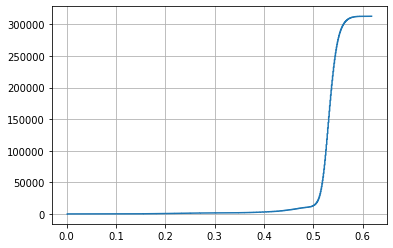

In [216]:
plt.plot(np.sort(sample_dists[sample_dists>0])/dataset.L,np.arange(np.sum(sample_dists>0)))
# plt.xscale('log')
# plt.yscale('log')
plt.grid('on')

In [217]:
print(len(df))
px.scatter(df, df.ed/dataset.L, y='embed_dist', hover_data=["ed_sh","sample"], color="indexed")

1603


In [214]:
r = np.random.randint(len(df))
r = 322
sh1,sh2 = 0,0
L = dataset.L  

i1,j1,i2,j2 = df[['id1','pos1', 'id2', 'pos2']].iloc[r]
id1,id2 = dataset.ids[i1], dataset.ids[i2]

s1, s2 = dataset.seqs[i1][j1+sh1:j1+sh1+L], dataset.seqs[i2][j2+sh2:j2+sh2+L]
print(f"{id1} | {j1} ")
print(f"{id2} | {j2} ")
seq_alignment_viewer(s1,s2,p=-1)

i1,j1,i2,j2

NC_024490.1 Mirabilis leaf curl India virus associated betasatellite complete sequence, isolate Pragpur | 0 
NC_038924.1 Mirabilis leaf curl betasatellite complete sequence, isolate Himachal | 0 
{'c': 927, 's': 10, 'i': 87, 'd': 87}

   <<<<  << < <<<<<<<< << <  <<  <<<     <<  <<<< <<<<<<<<<<<<<<<< << <<<<<<<< << <<<  <<<<<<<<<<<<<
accggatggtcgcgatttttttgaacggatggctgtgatttacttaaagtgggccccacaaaaggatggctgtgatttatttaaagtgggccccacaaaa
acc----gg--g-g--------g--c-ga--gc---gattt--tt----t----------------t--c--------a--t---gt-------------

<<< << < <<< < <<<<                                ..                           .                   
cagtaactgacaatgacaagtgggccccacttttgacagagaagaaaatgtcaacctggtcaatgcaattgtgcgtaaattttatgggcttttgttattg
---t--c-g---a-g----gtgggccccacttttgacagagaagaaaatgttgacctggtcaatgcaattgtgcgtaaatcttatgggcttttgttattg

                                                                                                    
ggcttttattttatgggcttttgttattgggcttttatattggactttaaaaaata

(594, 0, 405, 0)

## all pairs analysis 

In [34]:
%%time 

d1 = .2
d2 = .35
recall = .99
max_len = 1500
ed_th = .15

# NN, NN_dists = KNN.nn(embeddings, d1, d2, recall=recall)
# NN_dists = KNN.nn_dists(embeddings, NN)
# NN, NN_dists = KNN.nn_index(embeddings, d1, d2, recall)
# index = KNN.nn2index(NN,NN_dists)

_, recall = KNN.PR_curve(NN, embed_dists<d1)
_, recall2 = KNN.PR_curve(NN, edit_dists/dataset.L<ed_th)
print(f"recall embed dist = {recall:.5f}\n"
      f"recall edit dist = {recall2:.5f}\n"
      f"embed dist calls per sample {int(NN.shape[0]/len(dataset))}")

# len(dataset), embeddings.shape, NN.shape, NN.shape[0]/len(dataset)

recall embed dist = 0.97072
recall edit dist = 0.97817
embed dist calls per sample 579
CPU times: user 4.88 s, sys: 6.12 s, total: 11 s
Wall time: 11 s
